# EDA
## Import necessary libraries 

In [103]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import warnings
import numpy as np
import requests
from io import StringIO
import nfl_data_py as nfl

# Suppress specific FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Load the data from digital ocean

In [104]:
# Define the base path and URLs as per your config file
BASE_CDN_PATH = "https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com"
TRACKING_DATA_URL_TEMPLATE = BASE_CDN_PATH + "/raw/tracking_data/tracking_week_{week}.csv"
PLAYS_URL = BASE_CDN_PATH + "/raw/plays.csv"
GAMES_URL = BASE_CDN_PATH + "/raw/games.csv"
PLAYERS_URL = BASE_CDN_PATH + "/raw/players.csv"
COLORS_URL = BASE_CDN_PATH + "/raw/colors.csv"
TACKLES_URL = BASE_CDN_PATH + "/raw/tackles.csv"

# Replace 'week' with the actual week number you want to download
week_number = 1
TRACKING_DATA_URL = TRACKING_DATA_URL_TEMPLATE.format(week=week_number)

# Define a function to download and return a DataFrame
def download_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        # Assuming the data is in CSV format
        return pd.read_csv(StringIO(response.text))
    else:
        print(f"Failed to download data from {url}")
        return None


# Download the data
tracking_data = download_data(TRACKING_DATA_URL)
plays_data = download_data(PLAYS_URL)
players_data = download_data(PLAYERS_URL)
colors_data = download_data(COLORS_URL)
tackles_data = download_data(TACKLES_URL)
games_data = download_data(GAMES_URL) 

In [105]:
print(tracking_data.info())
print(plays_data.info())
print(players_data.info())
print(colors_data.info())
print(tackles_data.info())
print(games_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407439 entries, 0 to 1407438
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   gameId         1407439 non-null  int64  
 1   playId         1407439 non-null  int64  
 2   nflId          1346246 non-null  float64
 3   displayName    1407439 non-null  object 
 4   frameId        1407439 non-null  int64  
 5   time           1407439 non-null  object 
 6   jerseyNumber   1346246 non-null  float64
 7   club           1407439 non-null  object 
 8   playDirection  1407439 non-null  object 
 9   x              1407439 non-null  float64
 10  y              1407439 non-null  float64
 11  s              1407439 non-null  float64
 12  a              1407439 non-null  float64
 13  dis            1407439 non-null  float64
 14  o              1346397 non-null  float64
 15  dir            1346397 non-null  float64
 16  event          130268 non-null   object 
dtypes: float

## Load DATA from pipeline

In [106]:
df = pd.read_csv('/Users/nick/nfl-big-data-bowl-2024/data/final_pso_pipeline_results_week_1_completions_only_run4.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# # Loop through weeks 2 to 9
# for week in range(1, 10):
#     # Construct file path for the current week
#     file_path = f'/Users/nick/nfl-big-data-bowl-2024/data/final_pso_pipeline_results_week_{week}_completions_only_run3.csv'
    
#     # Read the data
#     week_df = pd.read_csv(file_path)
    
#     # Remove any unnamed columns
#     week_df = week_df.loc[:, ~week_df.columns.str.contains('^Unnamed')]
    
#     # Append to the original DataFrame
#     df = pd.concat([df, week_df], ignore_index=True)


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nflId                3231 non-null   float64
 1   frechet_distance     3231 non-null   float64
 2   play_id              3231 non-null   int64  
 3   game_id              3231 non-null   int64  
 4   week_num             3231 non-null   int64  
 5   displayName          3231 non-null   object 
 6   position             3231 non-null   object 
 7   gameId               3231 non-null   int64  
 8   playId               3231 non-null   int64  
 9   passResult           3215 non-null   object 
 10  expectedPointsAdded  3231 non-null   float64
 11  defensiveTeam        3231 non-null   object 
dtypes: float64(3), int64(5), object(4)
memory usage: 303.0+ KB


In [108]:
#sanity check
plays_per_game = df.groupby('gameId')['play_id'].nunique()

# Calculating the average number of plays per game
average_plays_per_game = plays_per_game.mean()
average_plays_per_game

40.8125

In [109]:
#sanity check
games = df['game_id'].nunique()
games

16

20 per team seems reasonable 

In [110]:
# Merge the DataFrames on 'playId' and 'nflId'
frechet_tackles_df = pd.merge(df, tackles_data, left_on=['playId', 'nflId','gameId'], right_on=['playId', 'nflId','gameId'], how='left')

In [111]:
frechet_tackles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nflId                3231 non-null   float64
 1   frechet_distance     3231 non-null   float64
 2   play_id              3231 non-null   int64  
 3   game_id              3231 non-null   int64  
 4   week_num             3231 non-null   int64  
 5   displayName          3231 non-null   object 
 6   position             3231 non-null   object 
 7   gameId               3231 non-null   int64  
 8   playId               3231 non-null   int64  
 9   passResult           3215 non-null   object 
 10  expectedPointsAdded  3231 non-null   float64
 11  defensiveTeam        3231 non-null   object 
 12  tackle               530 non-null    float64
 13  assist               530 non-null    float64
 14  forcedFumble         530 non-null    float64
 15  pff_missedTackle     530 non-null    f

In [112]:
import pandas as pd

# Assuming df is your DataFrame
# Fill NaN values in defensive stats with 0
frechet_tackles_df[['tackle', 'assist', 'forcedFumble']] = frechet_tackles_df[['tackle', 'assist', 'forcedFumble']].fillna(0)

# Selecting non-ID and defensive stats columns
columns_of_interest = ['frechet_distance', 'expectedPointsAdded', 'tackle', 'assist', 'forcedFumble']

# Calculate correlation
correlation_matrix = frechet_tackles_df[columns_of_interest].corr()

print(correlation_matrix)


                     frechet_distance  expectedPointsAdded    tackle  \
frechet_distance             1.000000             0.206480  0.000733   
expectedPointsAdded          0.206480             1.000000  0.020590   
tackle                       0.000733             0.020590  1.000000   
assist                      -0.067398            -0.023086 -0.063505   
forcedFumble                -0.019240            -0.055645  0.117865   

                       assist  forcedFumble  
frechet_distance    -0.067398     -0.019240  
expectedPointsAdded -0.023086     -0.055645  
tackle              -0.063505      0.117865  
assist               1.000000      0.027960  
forcedFumble         0.027960      1.000000  


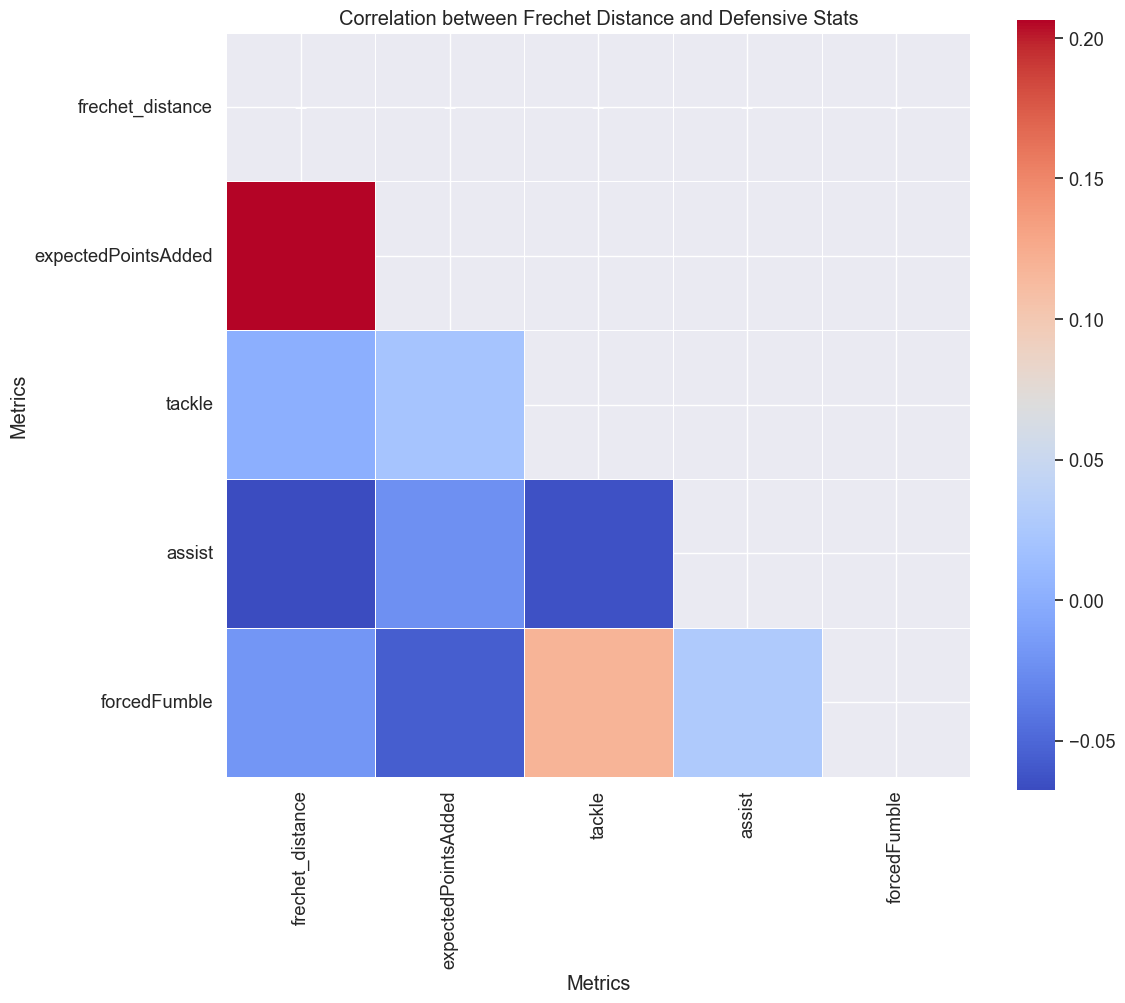

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'frechet_tackles_df' is a predefined DataFrame with relevant data
# Make sure to replace the sample data creation with your actual DataFrame

# Fill NaN values with 0 in the DataFrame
frechet_tackles_df[['tackle', 'assist', 'forcedFumble']] = frechet_tackles_df[['tackle', 'assist', 'forcedFumble']].fillna(0)

# Selecting the columns of interest
columns_of_interest = ['frechet_distance', 'expectedPointsAdded', 'tackle', 'assist', 'forcedFumble']

# Calculate the correlation matrix
correlation_matrix = frechet_tackles_df[columns_of_interest].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Increase the figure size and adjust font scale for better visibility
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)

# Create a heatmap with a mask for the upper triangle
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)

# Adding titles and labels for clarity
plt.title('Correlation between Frechet Distance and Defensive Stats')
plt.xlabel('Metrics')
plt.ylabel('Metrics')

# Show the plot
plt.show()


High correlation here because the players are traviling farther and farther away from the frechet distance when a secondary player makes a tackle. 

In [114]:
df

,nflId,frechet_distance,play_id,game_id,week_num,displayName,position,gameId,playId,passResult,expectedPointsAdded,defensiveTeam
0,42816.0,5.745254,56,2022090800,1,Troy Hill,CB,2022090800,56,C,0.004420,LA
1,43294.0,2.427862,56,2022090800,1,Jalen Ramsey,CB,2022090800,56,C,0.004420,LA
2,47844.0,1.633529,56,2022090800,1,Taylor Rapp,FS,2022090800,56,C,0.004420,LA
3,48026.0,3.989935,56,2022090800,1,Nick Scott,SS,2022090800,56,C,0.004420,LA
4,52607.0,2.183635,56,2022090800,1,Jordan Fuller,SS,2022090800,56,C,0.004420,LA
...,...,...,...,...,...,...,...,...,...,...,...,...
3226,42827.0,8.406694,3826,2022091200,1,Justin Coleman,CB,2022091200,3826,C,-0.719924,SEA
3227,44873.0,9.102757,3826,2022091200,1,Josh Jones,FS,2022091200,3826,C,-0.719924,SEA
3228,46711.0,3.565946,3826,2022091200,1,Ryan Neal,SS,2022091200,3826,C,-0.719924,SEA
3229,47941.0,4.855469,3826,2022091200,1,Michael Jackson,CB,2022091200,3826,C,-0.719924,SEA


In [115]:
# Define the years and columns of interest
years = [2022]
columns = ['old_game_id', 'play_id', 'yards_after_catch', 
           'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage', 
           'comp_yac_epa', 'comp_yac_wpa', 'week']

# Import the play-by-play data
pbp_data = nfl.import_pbp_data(years, columns)

# Filter for weeks 1-9
filtered_pbp_data = pbp_data[pbp_data['week'].between(1, 10)]

# Ensure the data types for merging columns are consistent
filtered_pbp_data['old_game_id'] = filtered_pbp_data['old_game_id'].astype(int)
df['gameId'] = df['gameId'].astype(int)

# Import the play_level_frechet data
# You would need to specify how to import this data, as the method is not provided in your query

# Merge the data
data = pd.merge(filtered_pbp_data, df, left_on=['old_game_id', 'play_id'], right_on=['gameId', 'play_id'])


2022 done.
Downcasting floats.


/var/folders/kj/29dyy8nn54v_615jgbd59t7h0000gn/T/ipykernel_41913/3311383526.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pbp_data['old_game_id'] = filtered_pbp_data['old_game_id'].astype(int)


In [116]:
data.columns

Index(['old_game_id', 'play_id', 'yards_after_catch', 'xyac_epa',
       'xyac_mean_yardage', 'xyac_median_yardage', 'comp_yac_epa',
       'comp_yac_wpa', 'week', 'season', 'nflverse_game_id', 'possession_team',
       'offense_formation', 'offense_personnel', 'defenders_in_box',
       'defense_personnel', 'number_of_pass_rushers', 'players_on_play',
       'offense_players', 'defense_players', 'n_offense', 'n_defense',
       'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route',
       'defense_man_zone_type', 'defense_coverage_type', 'nflId',
       'frechet_distance', 'game_id', 'week_num', 'displayName', 'position',
       'gameId', 'playId', 'passResult', 'expectedPointsAdded',
       'defensiveTeam'],
      dtype='object')

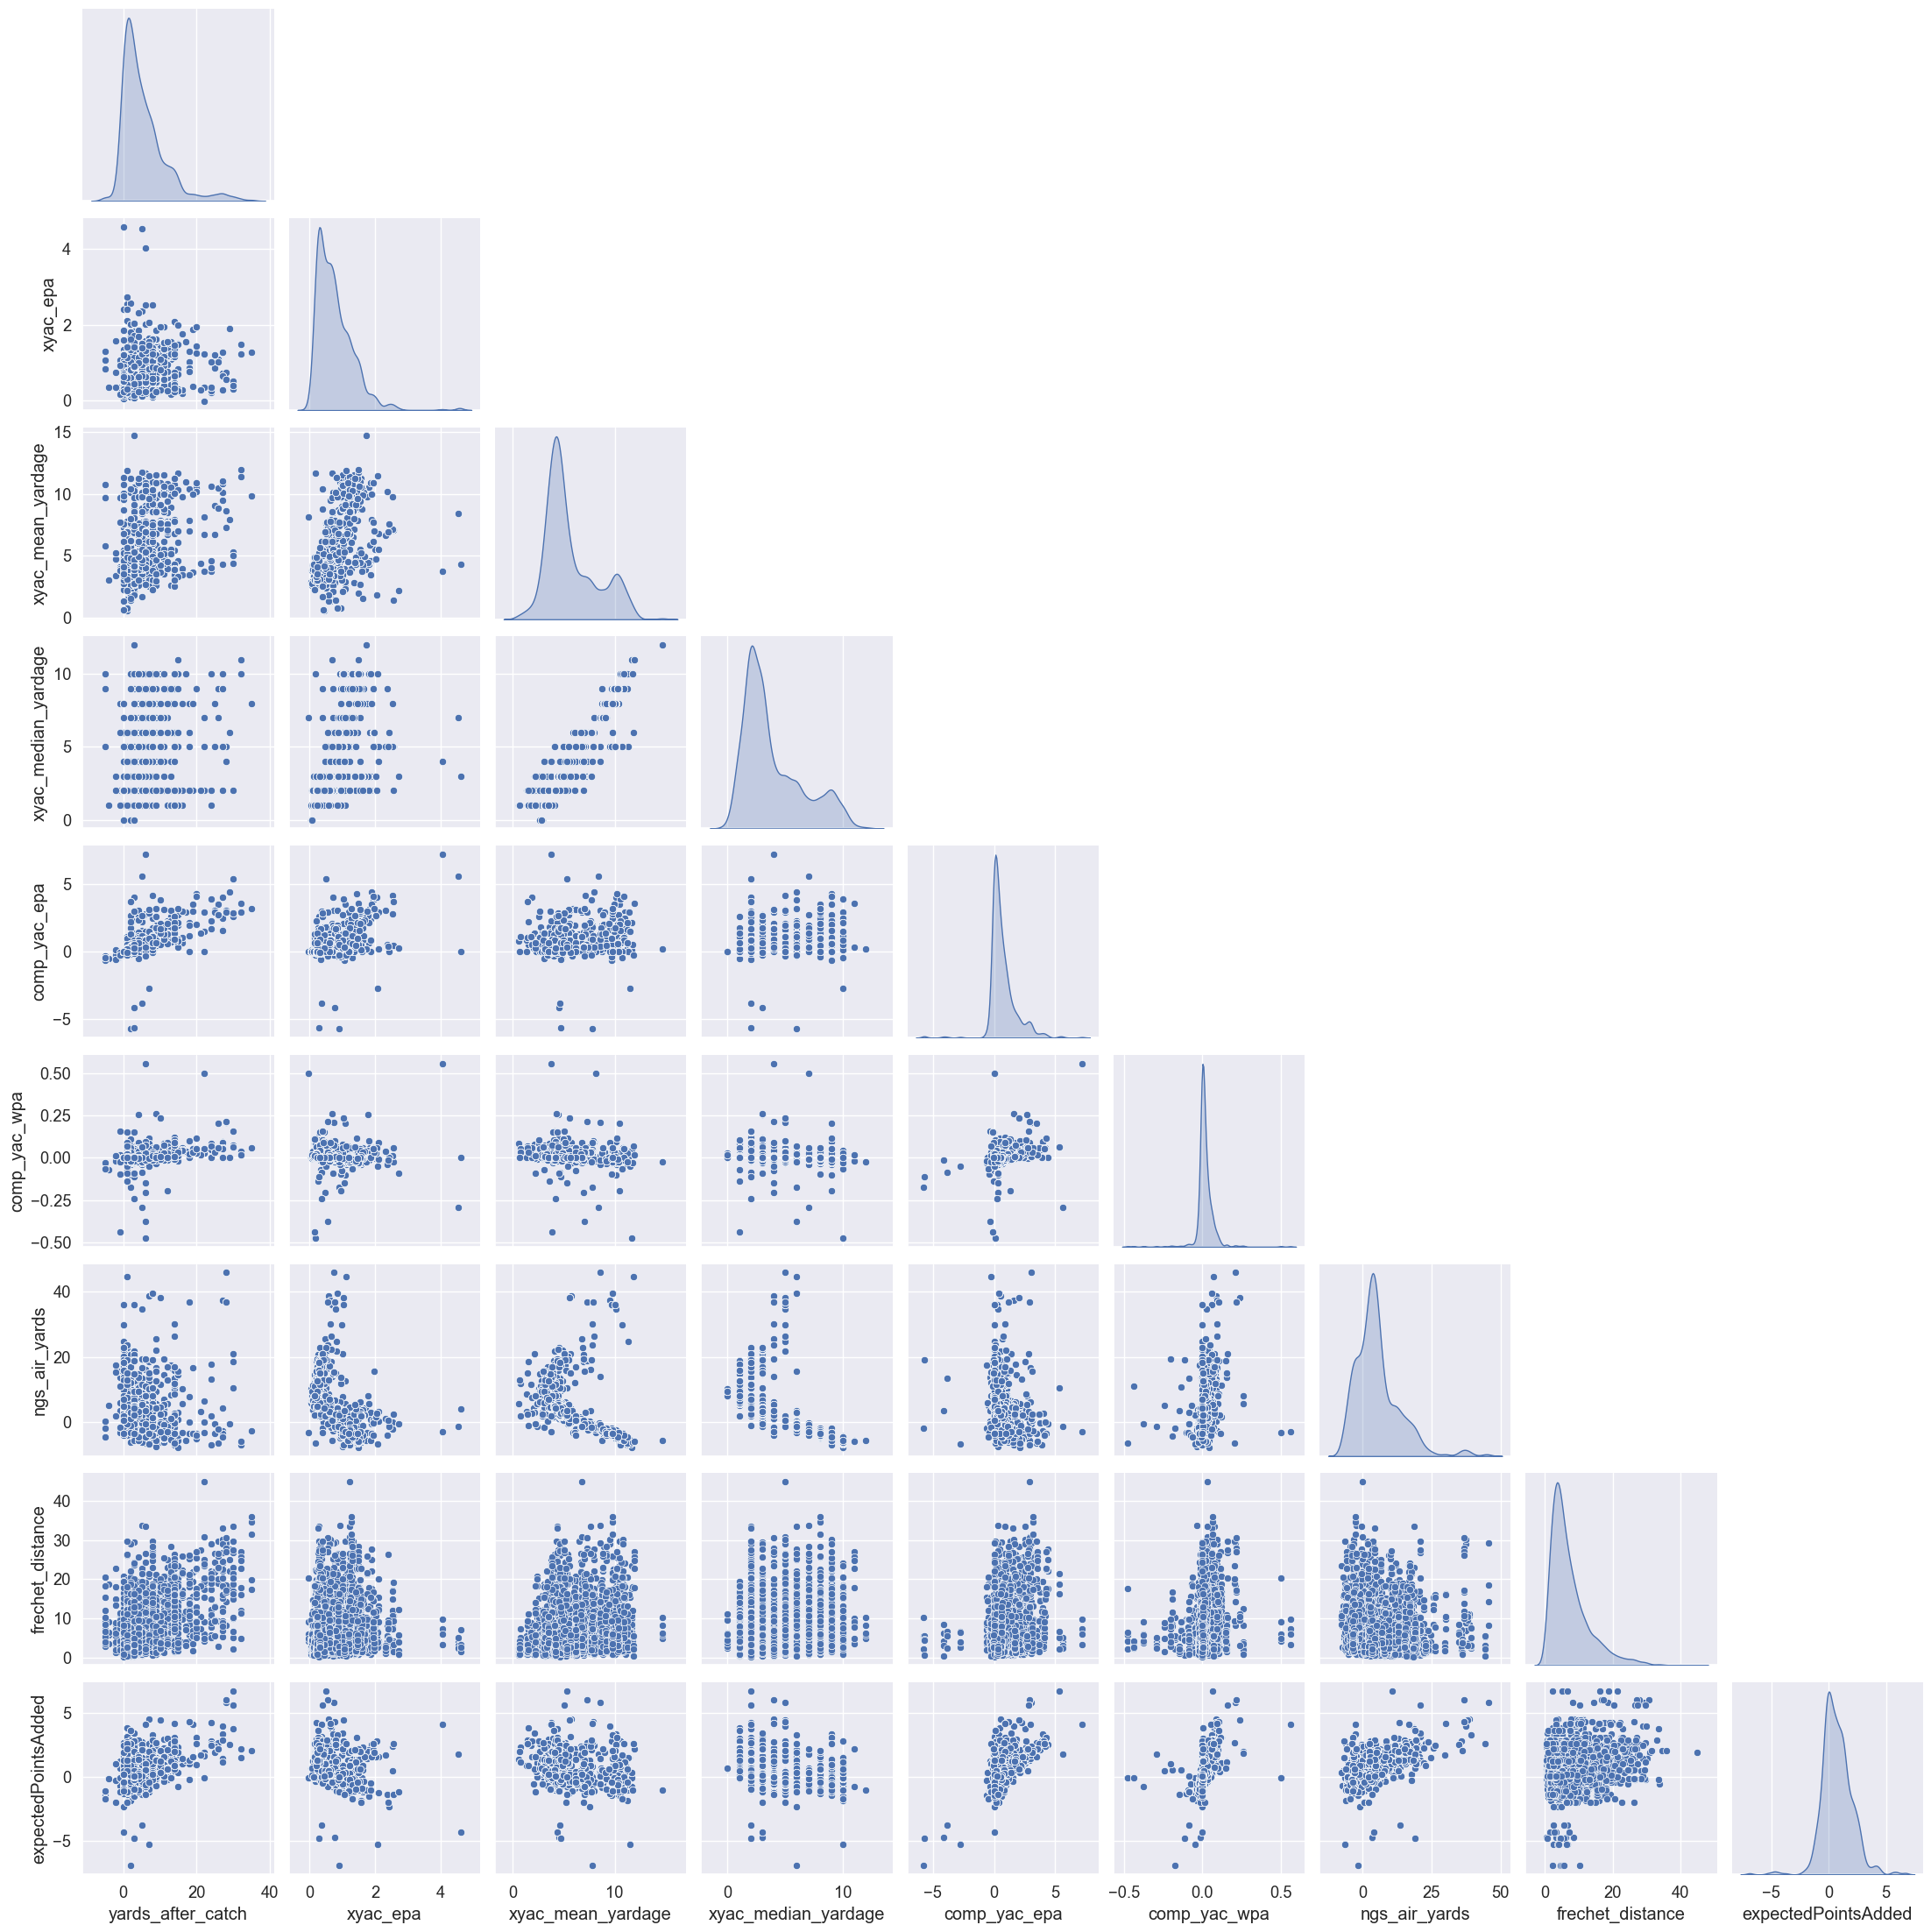

In [117]:
columns = ['yards_after_catch', 'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage', 
           'comp_yac_epa', 'comp_yac_wpa', 'ngs_air_yards', 'frechet_distance', 
           'position', 'passResult', 'expectedPointsAdded']

# Filtering the DataFrame to include only the selected columns
df_filtered = data[columns]

# Creating the pair plot
sns.pairplot(df_filtered, diag_kind = 'kde', corner=True)

# Displaying the plot
plt.show()

In [118]:
# Step 2: Calculate the difference between yards_after_catch and xyac_mean_yardage
data['yac_diff'] =  data['xyac_mean_yardage'] - data['yards_after_catch']
data['pasta'] = data['yac_diff'] / data['frechet_distance'] #this attributes yac diff to individual players based off 

In [119]:
# Aggregate at the player level to get averages across all plaue
player_level_agg = data.groupby(['nflId','displayName','position','defensiveTeam']).agg(
    total_frechet=('frechet_distance', 'sum'),
    average_frechet = ('frechet_distance', 'mean'),
    average_yac_diff = ('yac_diff', 'mean'),
    total_yac_diff = ('yac_diff','sum'), 
    average_yac = ('yards_after_catch', 'mean'),
    total_yac = ('yards_after_catch','sum'),
    average_comp_yac_epa = ('comp_yac_epa', 'mean'),
    total_comp_yac_epa = ('comp_yac_epa','sum'),
    number_of_plays = ('playId','nunique'),
    number_of_games= ('gameId','nunique'), 
    total_pasta = ('pasta', 'sum'), 
    average_pasta = ('pasta', 'mean')
).reset_index()

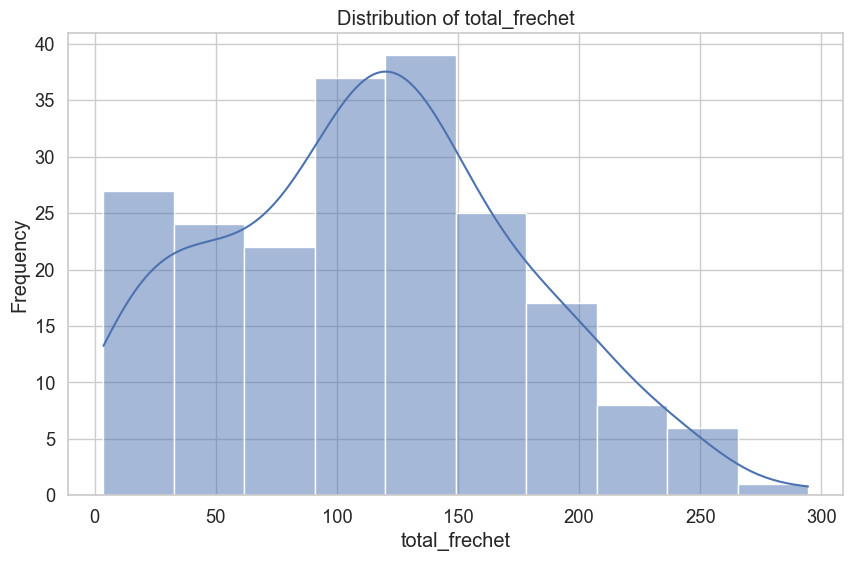

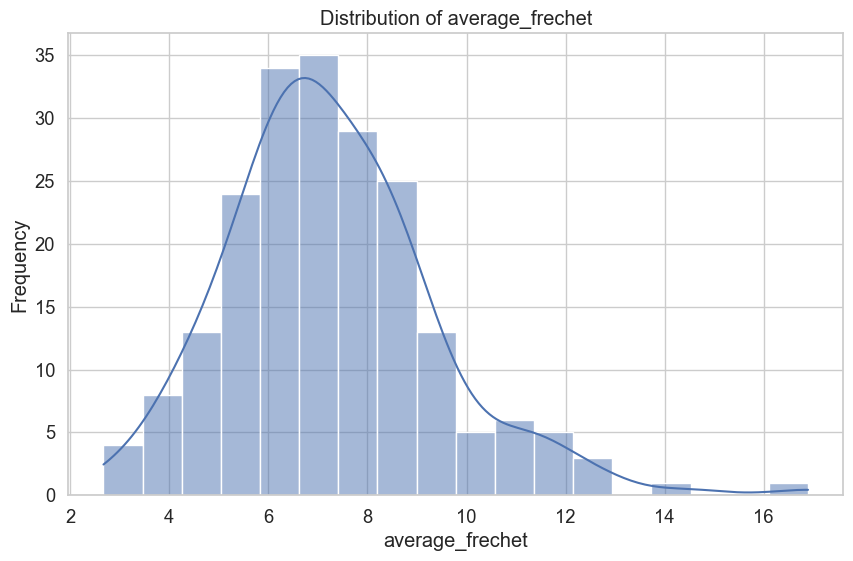

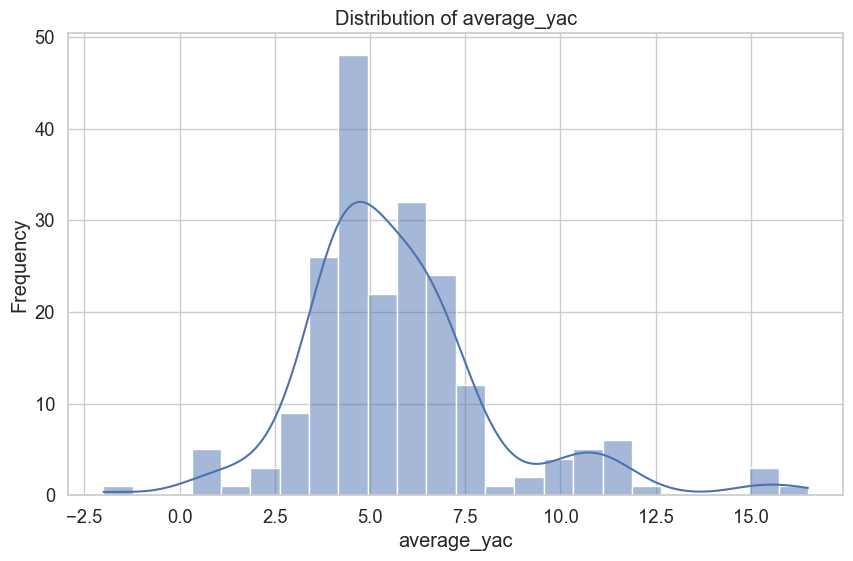

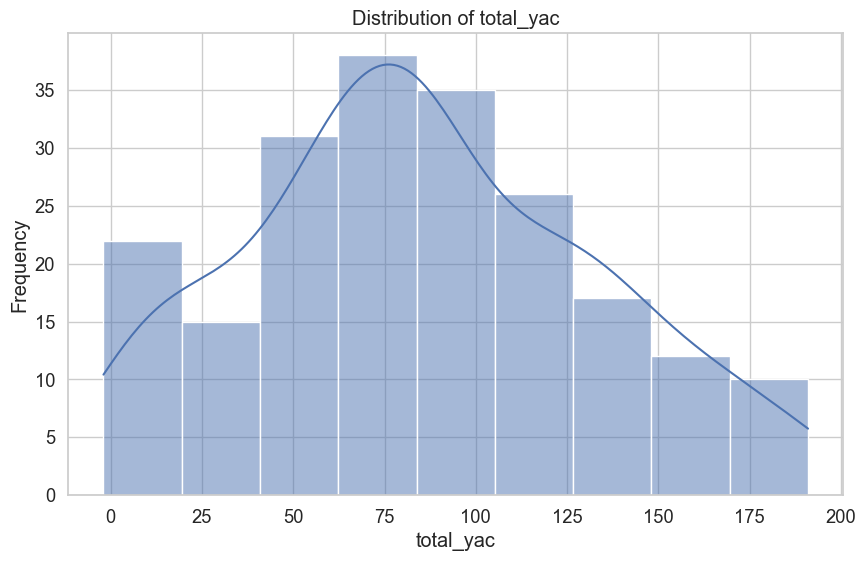

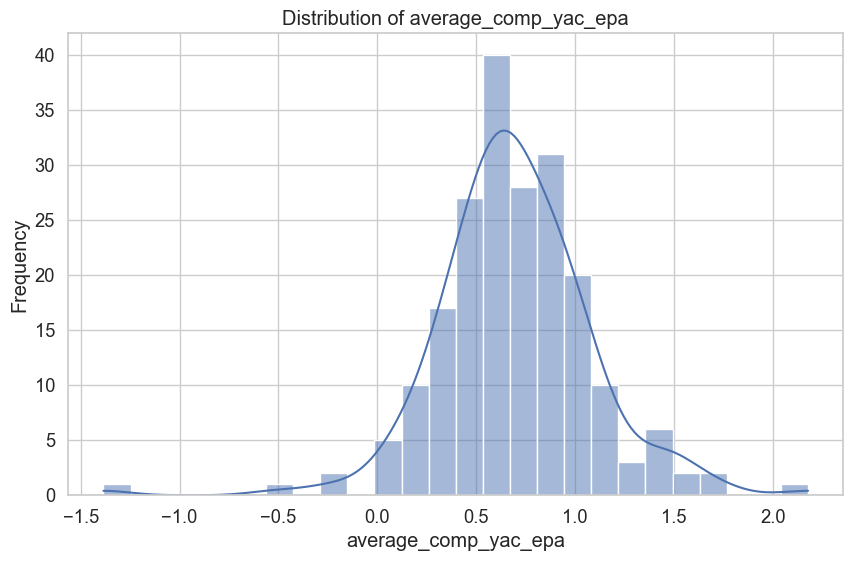

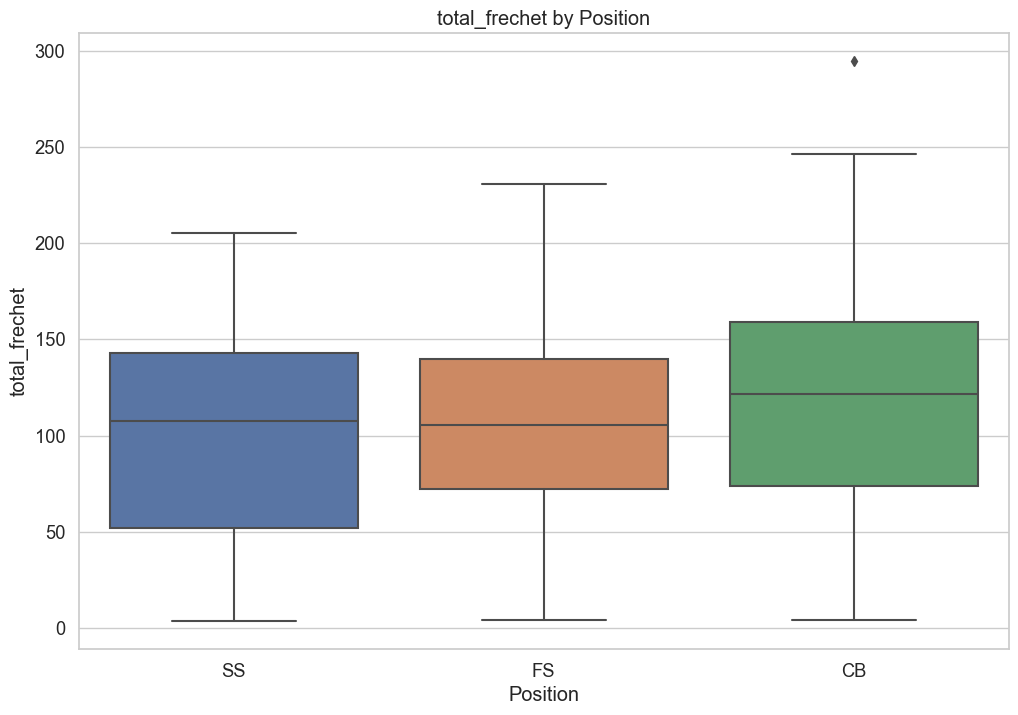

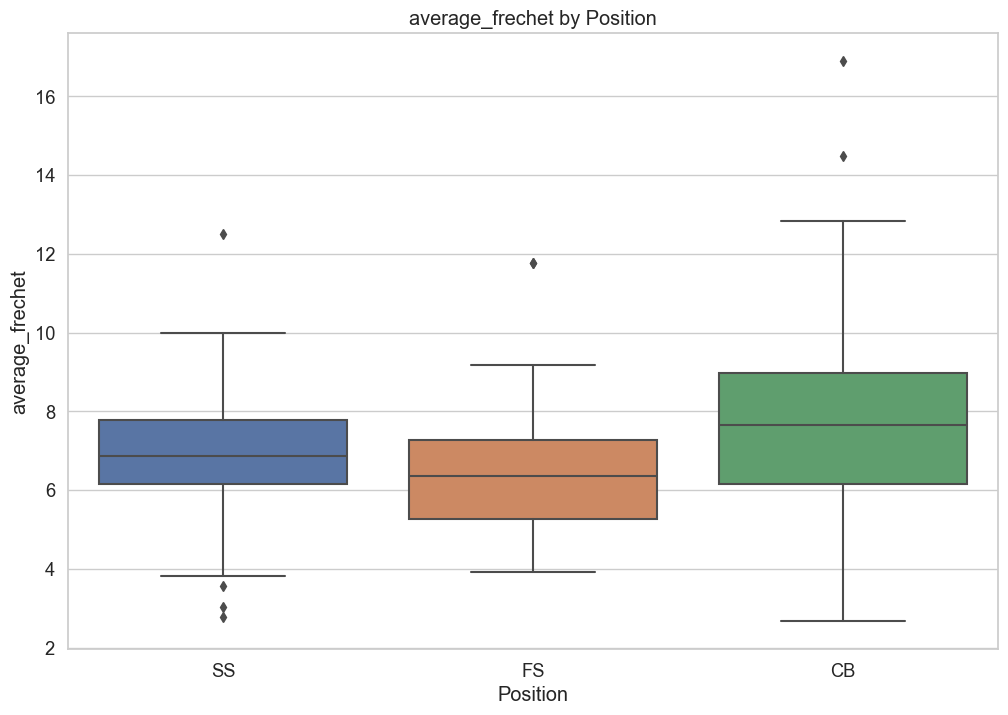

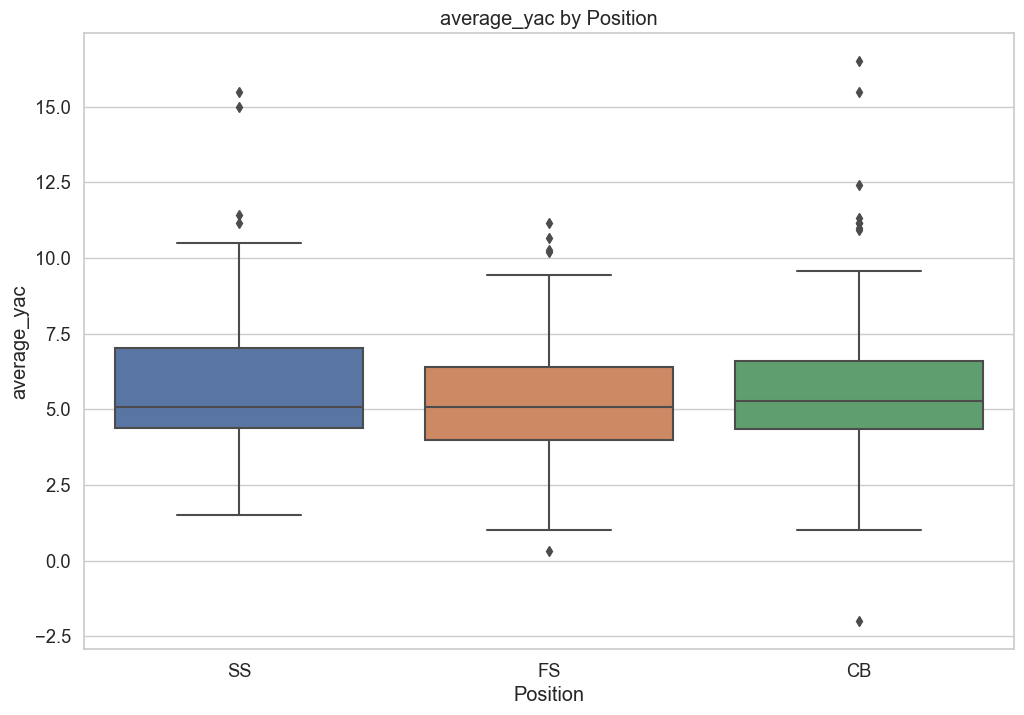

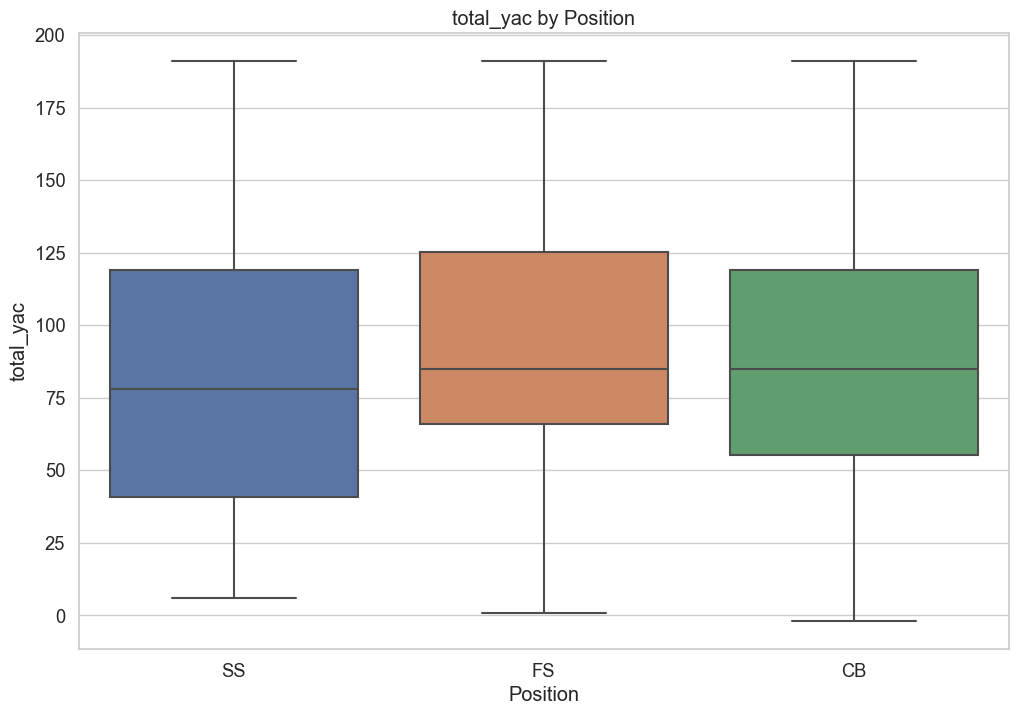

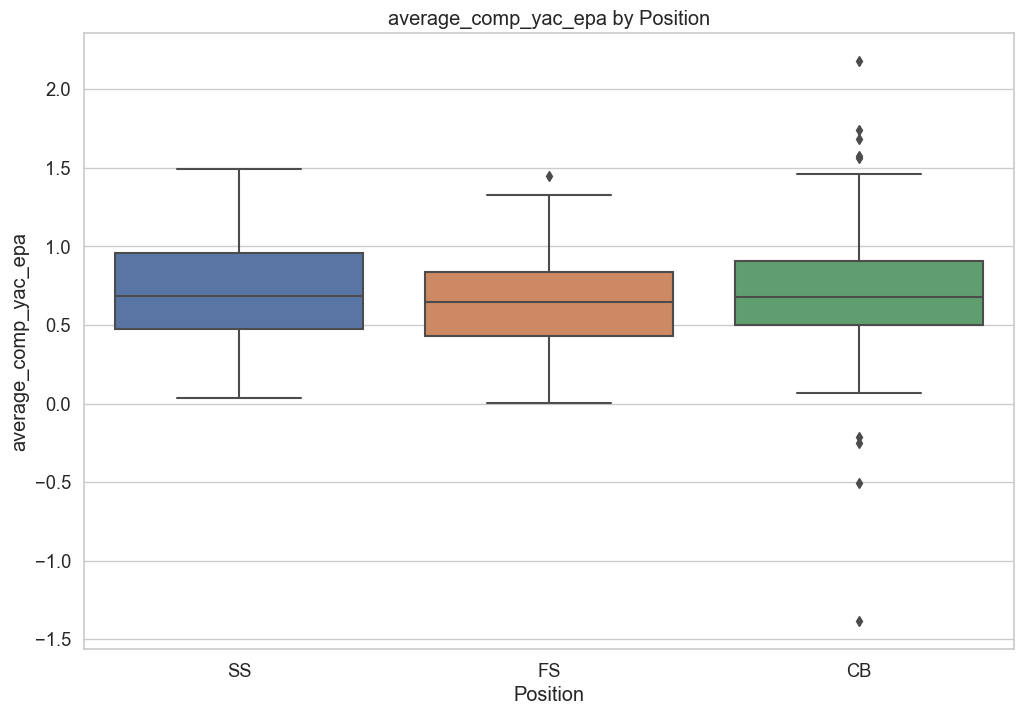

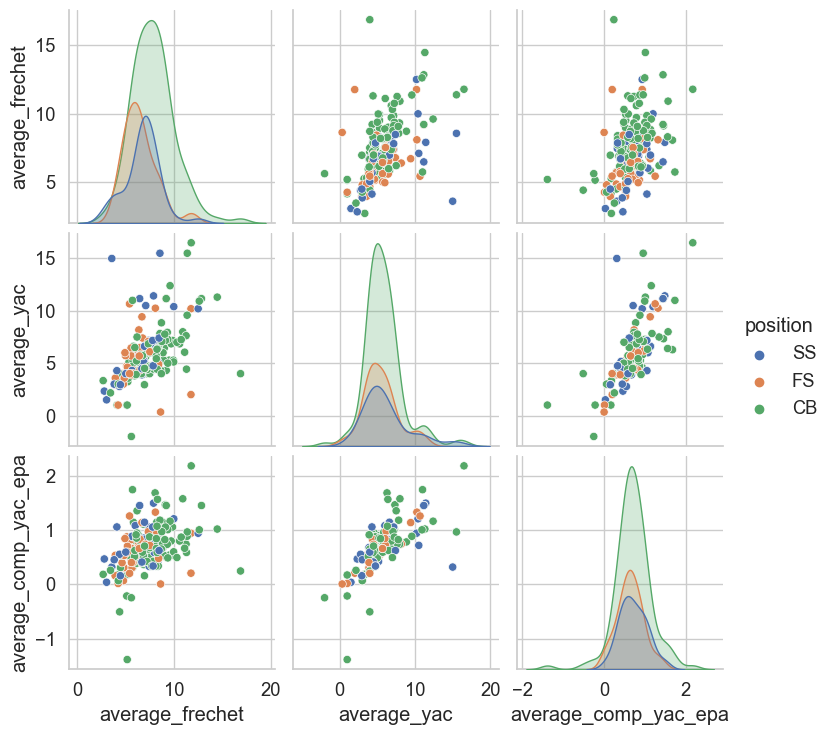

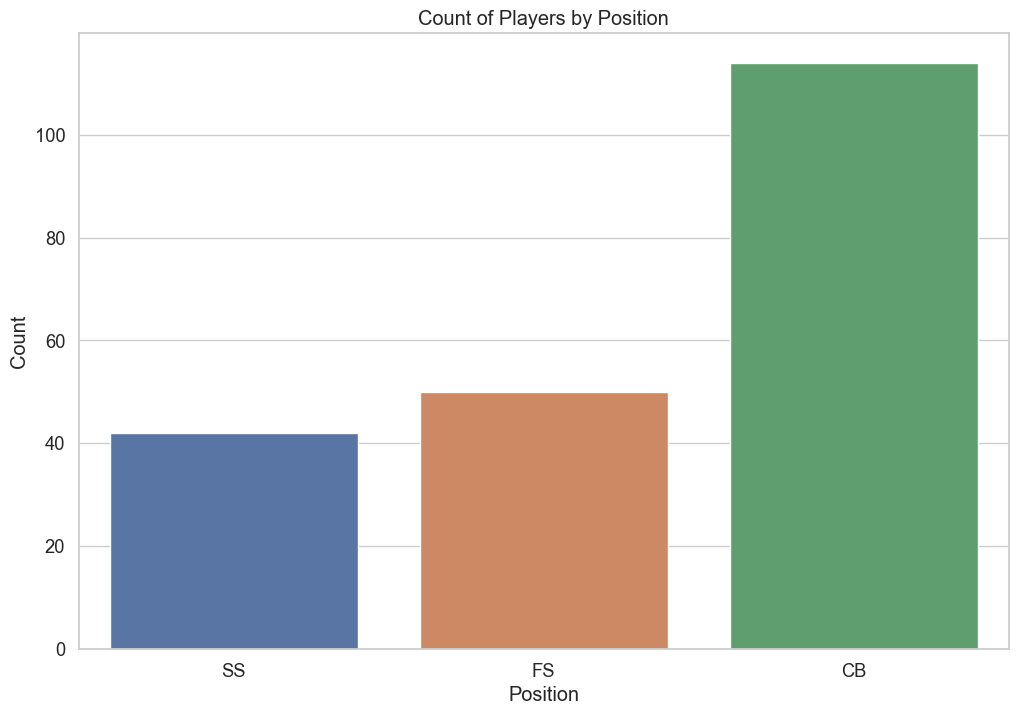

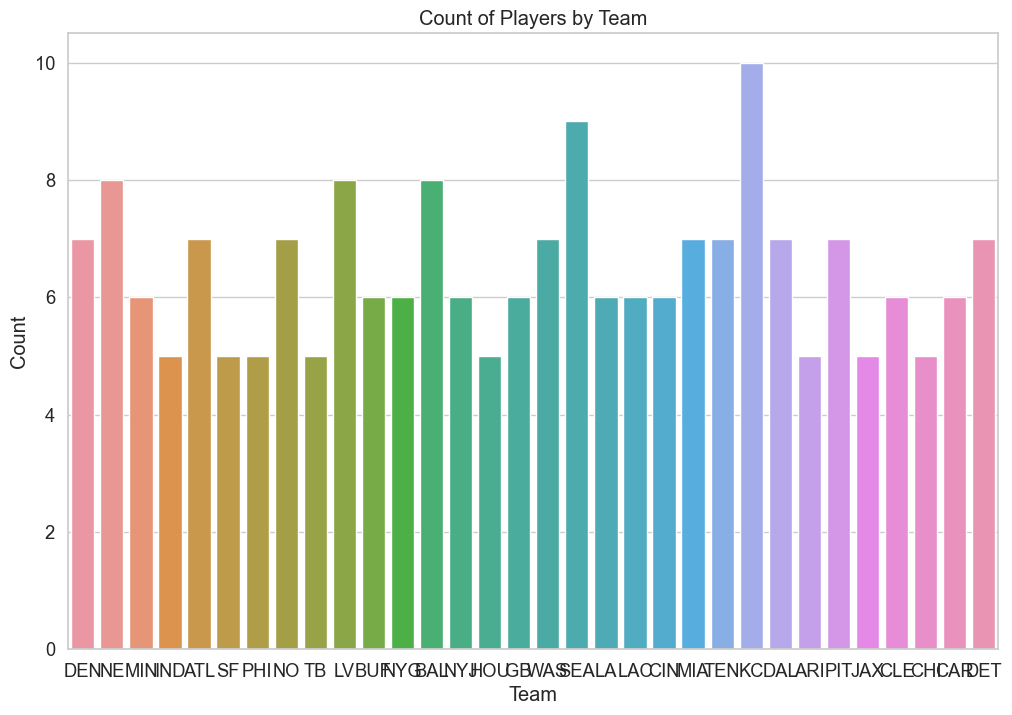

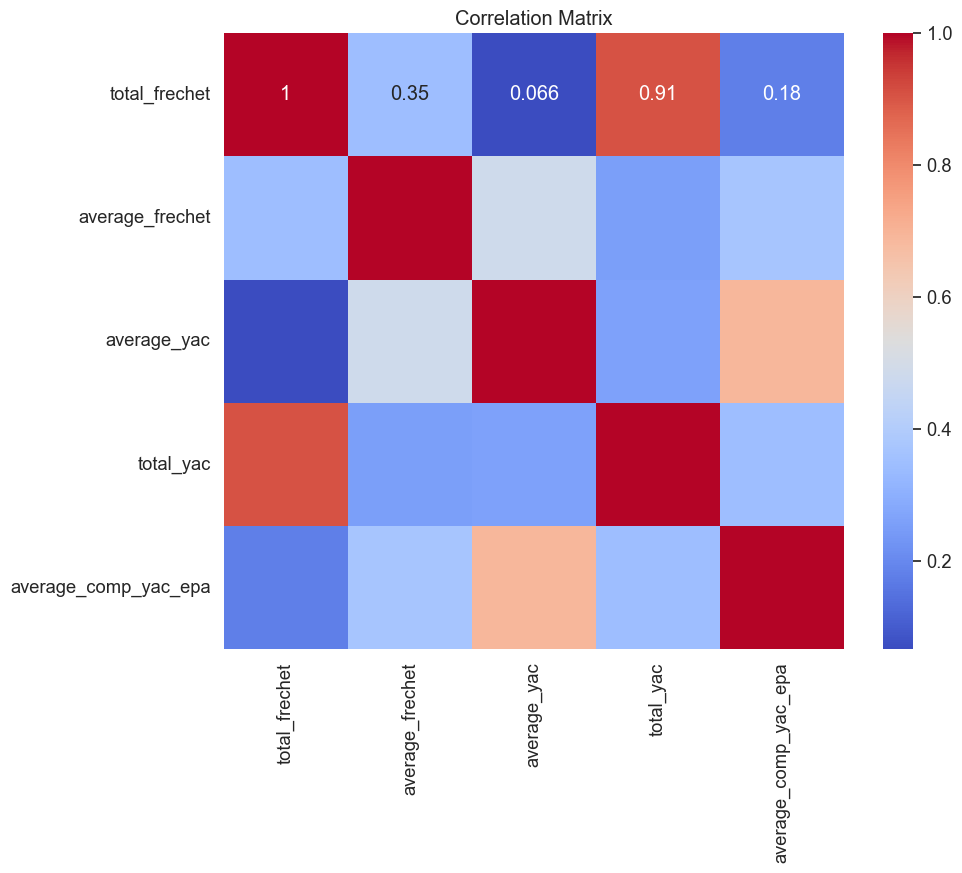

In [120]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Histograms/Density Plots for each metric
for column in ['total_frechet', 'average_frechet', 'average_yac', 'total_yac', 'average_comp_yac_epa']:
    plt.figure(figsize=(10, 6))
    sns.histplot(player_level_agg[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Box Plots for metrics by position
for column in ['total_frechet', 'average_frechet', 'average_yac', 'total_yac', 'average_comp_yac_epa']:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='position', y=column, data=player_level_agg)
    plt.title(f'{column} by Position')
    plt.ylabel(column)
    plt.xlabel('Position')
    plt.show()

# Pair Plot for select metrics
sns.pairplot(player_level_agg[['average_frechet', 'average_yac', 'average_comp_yac_epa', 'position']], hue='position')
plt.show()

# Count Plots for position and team
plt.figure(figsize=(12, 8))
sns.countplot(x='position', data=player_level_agg)
plt.title('Count of Players by Position')
plt.ylabel('Count')
plt.xlabel('Position')
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(x='defensiveTeam', data=player_level_agg)
plt.title('Count of Players by Team')
plt.ylabel('Count')
plt.xlabel('Team')
plt.show()

# Heatmap for correlation
corr_metrics = player_level_agg[['total_frechet', 'average_frechet', 'average_yac', 'total_yac', 'average_comp_yac_epa']]
corr = corr_metrics.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [121]:
# Aggregate at the team level to get averages across all plays per team
team_level_agg_per_play = data.groupby(['defensiveTeam','playId']).agg(
    average_frechet_per_player=('frechet_distance', 'mean'),
    total_frechet_all_player = ('frechet_distance', 'sum'),
    number_in_swarm = ('nflId', 'nunique'), 
    gameId = ('gameId' , 'first'),
    yac_diff = ('yac_diff','first'), 
    yac = ('yards_after_catch','first'),
    comp_yac_epa = ('comp_yac_epa','first'), 
    total_pasta = ('pasta', 'sum'), 
    average_pasta = ('pasta', 'mean')
).reset_index()


In [122]:
team_level_agg_per_play['number_in_swarm'].value_counts()

number_in_swarm
5    432
4    126
6     92
7      2
1      1
Name: count, dtype: int64

In [123]:
# Filter out plays with only one unique player
team_level_agg_per_play = team_level_agg_per_play[ team_level_agg_per_play['number_in_swarm'] > 1]

In [124]:
team_level_agg_per_play

,defensiveTeam,playId,average_frechet_per_player,total_frechet_all_player,number_in_swarm,gameId,yac_diff,yac,comp_yac_epa,total_pasta,average_pasta
0,ARI,171,6.175513,24.702053,4,2022091110,-0.436651,4.0,1.325358,-0.310987,-0.077747
1,ARI,195,5.866542,23.466169,4,2022091110,4.325502,6.0,0.897137,3.548240,0.887060
2,ARI,240,6.916808,34.584038,5,2022091110,-4.439716,7.0,0.314533,-3.792461,-0.758492
3,ARI,514,11.066768,44.267071,4,2022091110,-20.593819,32.0,2.891309,-8.987610,-2.246902
4,ARI,569,6.074052,24.296208,4,2022091110,-0.992150,5.0,0.393167,-0.759674,-0.189918
...,...,...,...,...,...,...,...,...,...,...,...
648,WAS,2962,7.886422,39.432108,5,2022091109,1.668899,2.0,0.191690,1.244700,0.248940
649,WAS,3357,3.620590,18.102952,5,2022091109,-8.487530,14.0,2.047062,-13.188694,-2.637739
650,WAS,3773,5.823986,29.119929,5,2022091109,4.606075,0.0,0.000000,4.320209,0.864042
651,WAS,4286,5.236122,26.180609,5,2022091109,2.468500,1.0,-0.248911,2.895099,0.579020


In [125]:
# Aggregate at the player level to get averages across all plaue
team_level_agg = team_level_agg_per_play.groupby('defensiveTeam').agg(
    total_frechet=('average_frechet_per_player', 'sum'),
    average_frechet = ('average_frechet_per_player', 'mean'),
    average_in_swarm = ('number_in_swarm', 'mean'), 
    average_yac_diff = ('yac_diff', 'mean'),
    total_yac_diff = ('yac_diff','sum'), 
    average_yac = ('yac', 'mean'),
    total_yac = ('yac','mean'),
    average_comp_yac_epa = ('comp_yac_epa', 'mean'),
    total_comp_yac_epa = ('comp_yac_epa','sum'), 
    total_pasta = ('total_pasta','sum'), 
    average_pasta = ('total_pasta', 'mean')
).reset_index()

In [126]:
player_level_agg = player_level_agg[player_level_agg['number_of_plays'] > 20]

In [127]:
player_level_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 188
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nflId                 50 non-null     float64
 1   displayName           50 non-null     object 
 2   position              50 non-null     object 
 3   defensiveTeam         50 non-null     object 
 4   total_frechet         50 non-null     float64
 5   average_frechet       50 non-null     float64
 6   average_yac_diff      50 non-null     float32
 7   total_yac_diff        50 non-null     float32
 8   average_yac           50 non-null     float32
 9   total_yac             50 non-null     float32
 10  average_comp_yac_epa  50 non-null     float32
 11  total_comp_yac_epa    50 non-null     float32
 12  number_of_plays       50 non-null     int64  
 13  number_of_games       50 non-null     int64  
 14  total_pasta           50 non-null     float64
 15  average_pasta         50 non-

In [128]:
# Merge the aggregated data with the team colors data
team_df_with_colors = team_level_agg.merge(colors_data, left_on='defensiveTeam', right_on='team_abbr')
player_df_with_colors = player_level_agg.merge(colors_data, left_on='defensiveTeam', right_on='team_abbr')


In [129]:
team_df_with_colors.columns

Index(['defensiveTeam', 'total_frechet', 'average_frechet', 'average_in_swarm',
       'average_yac_diff', 'total_yac_diff', 'average_yac', 'total_yac',
       'average_comp_yac_epa', 'total_comp_yac_epa', 'total_pasta',
       'average_pasta', 'team_abbr', 'team_name', 'team_id', 'team_nick',
       'team_conf', 'team_division', 'team_color', 'team_color2',
       'team_color3', 'team_color4', 'team_logo_wikipedia', 'team_logo_espn',
       'team_wordmark', 'team_conference_logo', 'team_league_logo'],
      dtype='object')

In [130]:
# Save the DataFrame as a CSV file
team_df_with_colors.to_csv('team_level_filtered_completed_passes.csv', index=False)
player_df_with_colors.to_csv('player_level_filtered_completed_passes.csv', index=False)


In [131]:
player_df_with_colors.columns

Index(['nflId', 'displayName', 'position', 'defensiveTeam', 'total_frechet',
       'average_frechet', 'average_yac_diff', 'total_yac_diff', 'average_yac',
       'total_yac', 'average_comp_yac_epa', 'total_comp_yac_epa',
       'number_of_plays', 'number_of_games', 'total_pasta', 'average_pasta',
       'team_abbr', 'team_name', 'team_id', 'team_nick', 'team_conf',
       'team_division', 'team_color', 'team_color2', 'team_color3',
       'team_color4', 'team_logo_wikipedia', 'team_logo_espn', 'team_wordmark',
       'team_conference_logo', 'team_league_logo'],
      dtype='object')

In [132]:

# Sort by PASTA score and reset the index to keep defensiveTeam as a column
player_totals_scores = player_df_with_colors.sort_values(by='average_pasta', ascending=False).reset_index()

# Add PASTA rank
player_totals_scores['PASTA RANK'] = player_totals_scores['average_pasta'].rank(method='dense', ascending=False)

# Round all numerical columns to one decimal place
player_totals_scores = player_totals_scores.round(1)

# Optional: Drop the original index column if it's still there
if 'index' in player_totals_scores.columns:
    player_totals_scores.drop(columns=['index'], inplace=True)



In [133]:
# Sort by PASTA score and reset the index to keep defensiveTeam as a column
team_pasta_scores = team_df_with_colors.sort_values(by='average_pasta', ascending=False).reset_index()

# Add PASTA rank
team_pasta_scores['PASTA RANK'] = team_pasta_scores['average_pasta'].rank(method='dense', ascending=False)

# Round all numerical columns to one decimal place
team_pasta_scores = team_pasta_scores.round(1)

# Optional: Drop the original index column if it's still there
if 'index' in team_pasta_scores.columns:
    team_pasta_scores.drop(columns=['index'], inplace=True)




In [134]:
player_totals_scores.columns

Index(['nflId', 'displayName', 'position', 'defensiveTeam', 'total_frechet',
       'average_frechet', 'average_yac_diff', 'total_yac_diff', 'average_yac',
       'total_yac', 'average_comp_yac_epa', 'total_comp_yac_epa',
       'number_of_plays', 'number_of_games', 'total_pasta', 'average_pasta',
       'team_abbr', 'team_name', 'team_id', 'team_nick', 'team_conf',
       'team_division', 'team_color', 'team_color2', 'team_color3',
       'team_color4', 'team_logo_wikipedia', 'team_logo_espn', 'team_wordmark',
       'team_conference_logo', 'team_league_logo', 'PASTA RANK'],
      dtype='object')

In [135]:
# Assuming team_pasta_scores is your DataFrame
columns_of_interest = ['PASTA RANK','team_wordmark', 'average_pasta','average_yac_diff', 'average_frechet', 'average_comp_yac_epa', 'average_in_swarm']
team_pasta_rankings = team_pasta_scores[columns_of_interest]


# Assuming team_pasta_scores is your DataFrame
columns_of_interest = ['PASTA RANK','displayName','position','team_wordmark', 'average_pasta','average_yac_diff', 'average_frechet', 'average_comp_yac_epa','number_of_plays']
player_pasta_rankings = player_totals_scores[columns_of_interest]


In [136]:
from IPython.display import display, HTML

# Function to get the HTML representation of an image
def image_formatter(im):
    return f'<img src="{im}" width="100">'

# Create a copy of the DataFrame for display
display_df = team_pasta_rankings.copy()

# Apply the image formatter
display_df['team_wordmark'] = display_df['team_wordmark'].map(image_formatter)

# Convert DataFrame to HTML and display
display(HTML(display_df.to_html(escape=False)))


,PASTA RANK,team_wordmark,average_pasta,average_yac_diff,average_frechet,average_comp_yac_epa,average_in_swarm
0,1.0,,6.0,1.0,6.9,0.6,5.1
1,2.0,,5.6,3.0,5.3,0.2,4.8
2,3.0,,4.2,1.4,8.1,0.3,5.0
3,4.0,,4.1,2.0,7.2,0.4,4.7
4,5.0,,3.4,0.6,8.2,0.5,5.2
5,6.0,,3.3,2.1,6.1,0.4,4.8
6,7.0,,3.3,-1.2,6.0,0.6,5.0
7,8.0,,3.1,1.2,5.5,0.3,5.3
8,9.0,,2.9,1.4,6.9,0.8,4.8
9,10.0,,2.8,1.5,4.6,0.5,5.0


In [137]:
from IPython.display import display, HTML

# Function to get the HTML representation of an image
def image_formatter(im):
    return f'<img src="{im}" width="100">'

# Create a copy of the DataFrame for display
display_df = player_pasta_rankings.copy()

# Apply the image formatter
display_df['team_wordmark'] = display_df['team_wordmark'].map(image_formatter)

# Convert DataFrame to HTML and display
display(HTML(display_df.to_html(escape=False)))

,PASTA RANK,displayName,position,team_wordmark,average_pasta,average_yac_diff,average_frechet,average_comp_yac_epa,number_of_plays
0,1.0,Ronald Darby,CB,,1.3,2.0,7.8,0.4,21
1,2.0,Antoine Winfield,FS,,1.1,1.5,4.9,0.5,21
2,3.0,Patrick Surtain,CB,,0.8,2.0,7.8,0.4,21
3,4.0,Devin McCourty,FS,,0.7,-0.8,6.3,0.9,21
4,5.0,Kareem Jackson,SS,,0.7,2.0,6.8,0.4,21
5,6.0,Justin Simmons,FS,,0.7,2.0,6.4,0.4,21
6,7.0,Mike Edwards,FS,,0.7,1.5,3.9,0.5,21
7,8.0,Jordan Poyer,SS,,0.6,1.1,6.3,0.9,26
8,9.0,Nate Hobbs,CB,,0.6,0.8,6.1,0.8,23
9,10.0,Taron Johnson,CB,,0.5,1.1,5.7,0.9,26


In [138]:

# Function to get the HTML representation of an image
def image_formatter(im):
    return f'<img src="{im}" width="100">'

# Apply the image formatter
top_players_by_position.loc[:, 'team_wordmark'] = player_pasta_rankings['team_wordmark'].apply(image_formatter)

# Display the DataFrame with styles
styles = [
    dict(selector="th", props=[("font-size", "110%"), ("text-align", "center")]),
    dict(selector="td", props=[("text-align", "center")]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]

html = (top_players_by_position.style
    .background_gradient(subset=['average_frechet'], cmap='coolwarm')
    .background_gradient(subset=['average_yac_diff'], cmap='coolwarm')
    .set_table_styles(styles)
    .to_html(escape=False)) # using to_html instead of render

# Display styled DataFrame side by side for each position
display(HTML(html))



,PASTA RANK,displayName,position,team_wordmark,total_pasta,average_yac_diff,average_frechet,average_comp_yac_epa,number_of_plays
0,1.000000,Ronald Darby,CB,,26.200000,2.000000,7.800000,0.400000,21
1,2.000000,Antoine Winfield,FS,,20.100000,1.500000,4.900000,0.500000,21
2,3.000000,Patrick Surtain,CB,,15.900000,2.000000,7.800000,0.400000,21
3,4.000000,Devin McCourty,FS,,14.500000,-0.800000,6.300000,0.900000,21
4,5.000000,Kareem Jackson,SS,,14.500000,2.000000,6.800000,0.400000,21
5,6.000000,Justin Simmons,FS,,14.000000,2.000000,6.400000,0.400000,21
6,7.000000,Mike Edwards,FS,,12.400000,1.500000,3.900000,0.500000,21
7,8.000000,Jordan Poyer,SS,,15.300000,1.100000,6.300000,0.900000,26
8,9.000000,Nate Hobbs,CB,,13.200000,0.800000,6.100000,0.800000,23
9,10.000000,Taron Johnson,CB,,14.300000,1.100000,5.700000,0.900000,26


In [98]:
team_pasta_scores['defensiveTeam'].unique()

array(['DAL', 'ATL', 'CHI', 'DEN', 'CIN', 'CAR', 'NYG', 'NO', 'MIA', 'TB',
       'KC', 'BUF', 'LA', 'BAL', 'NE', 'IND', 'TEN', 'LV', 'SF', 'PHI',
       'WAS', 'NYJ', 'GB', 'LAC', 'SEA', 'JAX', 'DET', 'CLE', 'HOU',
       'MIN', 'PIT', 'ARI'], dtype=object)

need tp adjust and modify everything below here 

In [96]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(team_pasta_scores['average_pasta'], team_pasta_scores['average_comp_yac_epa'])


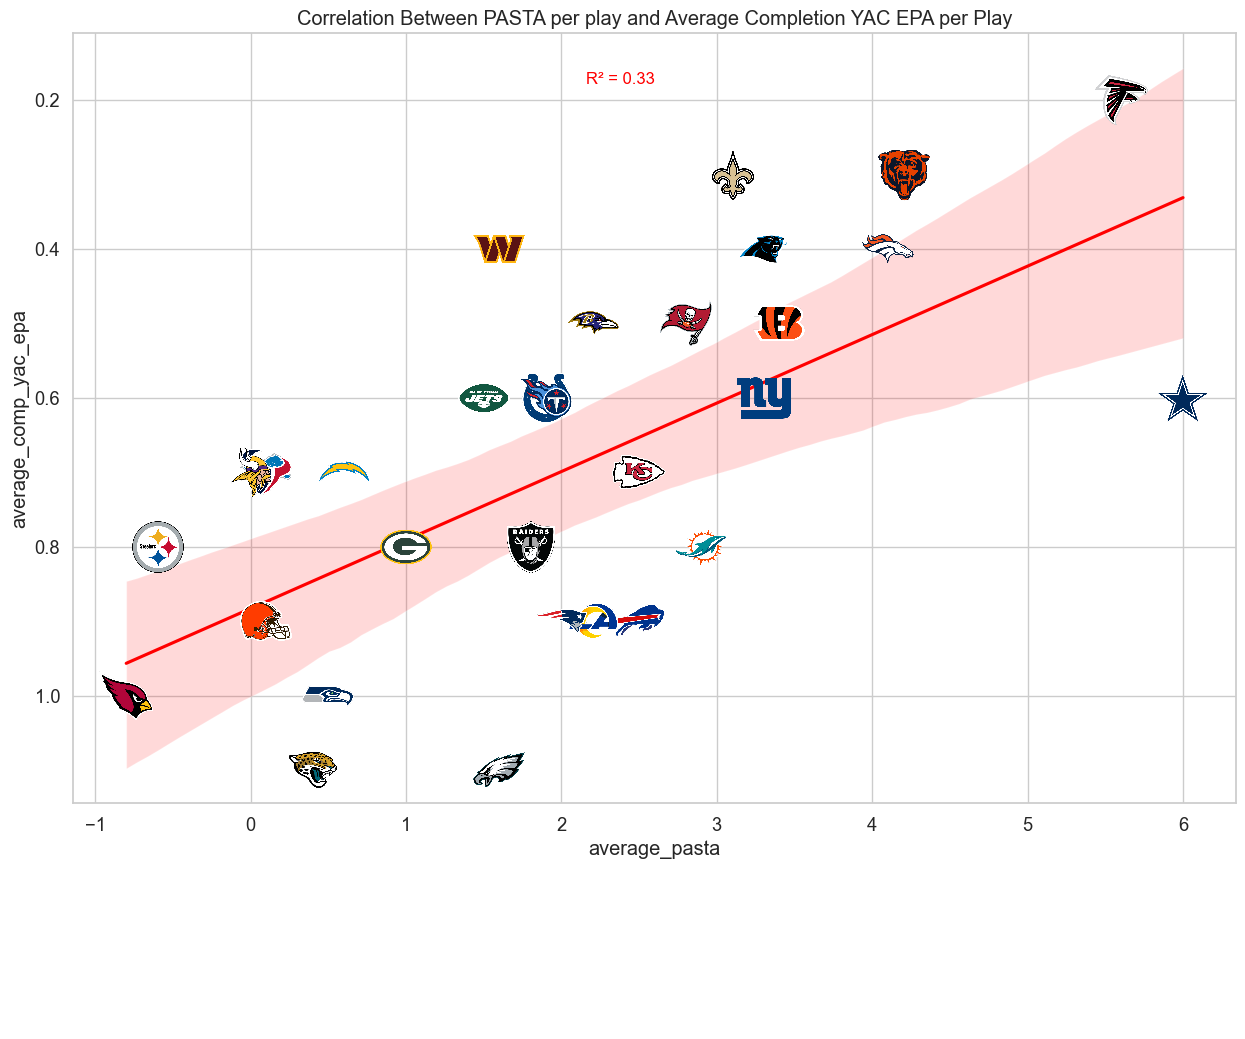

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Create the scatter plot with a regression line
fig, ax = plt.subplots(figsize=(15, 10))
sns.regplot(x='average_pasta', y='average_comp_yac_epa', data=team_pasta_scores, ax=ax, scatter=False, color='red')


# Plot each team with its logo
for index, row in team_pasta_scores.iterrows():
    # Load team logo from URL
    response = requests.get(row['team_logo_espn'])
    img = Image.open(BytesIO(response.content))

    # Convert image to a format suitable for matplotlib
    imagebox = OffsetImage(img, zoom=0.08)
    ab = AnnotationBbox(imagebox, (row['average_pasta'], row['average_comp_yac_epa']), frameon=False)
    ax.add_artist(ab)

# Set labels and title
ax.set_xlabel('average_pasta')
ax.set_ylabel('average_comp_yac_epa')
ax.set_title('Correlation Between PASTA per play and Average Completion YAC EPA per Play')
ax.text(0.5, 0.95, f'R\u00b2 = {r_value**2:.2f}', ha='right', va='top', transform=ax.transAxes, color='red', fontsize=12)
ax.invert_yaxis()
plt.show()


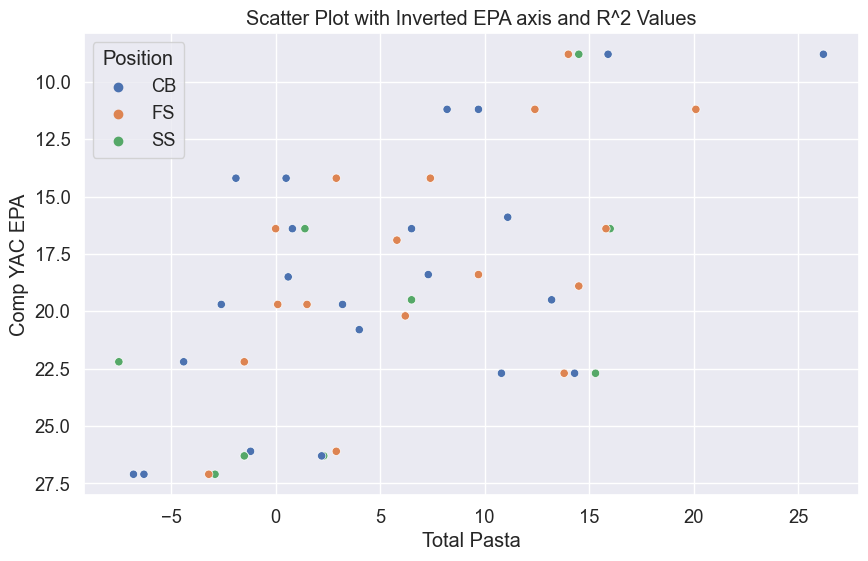

{'CB': -4.781335441723016, 'FS': -3.8726076112223833, 'SS': -5.01395129779596, 'All': -4.4392445803511835}


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for plotting
from sklearn.metrics import r2_score

# Assuming player_totals_scores is your DataFrame and has the required columns.

# Calculate R^2 values
r2_values = {}
positions = player_totals_scores['position'].unique()
for position in positions:
    subset = player_totals_scores[player_totals_scores['position'] == position]
    r2_values[position] = r2_score(subset['total_pasta'], subset['total_comp_yac_epa'])

# R^2 for all positions
r2_values['All'] = r2_score(player_totals_scores['total_pasta'], player_totals_scores['total_comp_yac_epa'])

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=player_totals_scores, x='total_pasta', y='total_comp_yac_epa', hue='position')

plt.xlabel('Total Pasta')
plt.ylabel('Comp YAC EPA')  # Update this label to reflect the correct metric
plt.title('Scatter Plot with Inverted EPA axis and R^2 Values')
plt.legend(title='Position')
plt.gca().invert_yaxis()  # Invert the y-axis

plt.grid(True)
plt.show()


# Print R^2 values
print(r2_values)


